# Avoiding Wireheading with Value Reinforcement Learning

The following iPython notebook illustrates the theory of the paper:

Avoiding Wireheading with Value Reinforcement Learning,
Tom Everitt and Marcus Hutter,
*Artificial General Intelligence*, 2016.
http://arxiv.org/abs/1605.03143

To run all code, choose Cell -> Run All in the menu above.

## Basic technical setup

The following cell imports some libraries that we will need.

In [132]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

verbose = 1
# 0 print nothing
# 1 print interesting things
# 2 print everything

and the next cell defines some generic helper methods (which are not that interesting).

In [133]:
# Helper methods

def sample(U, dist=None):
    """
    Sample from collection U and distribution dist 
    (method used for true utility function)
    """
    if dist is None:
        def dist(i):
            return 1/len(U)
    r = random.random()
    prob_threshold = 0
    # if round(sum(dist.values()), 3) != 1:
    #     print("Warning: dist sums to " + str(sum(dist.values())))
    for u in U:
        prob_threshold += dist(u)
        if r < prob_threshold:
            return u
    # something went wrong, nothing sampled:
    print("Warning: nothing sampled:", prob_threshold, "returning last U")
    return len(U)-1


def display_distributions(X, Y, dists):
    """arg dict( dist_name -> dist)"""
    for x in X:
        for d in dists:
            plt.plot(Y, [dists[d](y, x) for y in Y], label=d)
        plt.title("distributions " + str(x))  # , dists.keys())
        plt.legend()
        plt.show()


def check_Cu_accuracy(U, Cu):
    """
    Check how close estimated Cu is to the truth Bu.
    The quality should depend on which and how many states
    are provided in the list nd_states given to generate_Cu
    """
    Bu = generate_utility_prior(U)
    bu = [Bu(u) for u in U]
    cu = [Cu(u) for u in U]
    max_diff = max([abs(bu[u]-cu[u]) for u in U])
    print("Max diff of Cu from truth:", max_diff)


## Environment

We are now in position to define the environment. The environment class contains a list of possible rewards $R$,
a *true utility function* $u^*$, and a dictionary of states $S$ (on the form id -> state), where id is an integer (from 0 to 20).

States are formed by a an *inner state* $\hat s$, and a *delusion* $d$. The inner state $\hat s$ is just an integer, and the delusion $d$ is a function $R\to R$ that "subverts" the observed reward.

We use the following four delusions in our setup:
* *Non-delusion* does not subvert the reward at all
* *Inversion* shifts the sign of the reward $r\mapsto -r$
* *Delusion* always returns maximum reward (typical wireheading)
* *Bad delusion* always returns minimum reward (no agent should choose this delusion)

For simplicity, we assume that the agent simply chooses which state he wants to go to, so we don't really distinguish between actions and states.

In [134]:
def generate_states(R):
    """
    Generates a dictionary of S id -> (inner_state, delusion).
    The input R specifies possible reward values (needed for delusions)
    """
    inner_states = range(5)

    def d_non_delusion(r):
        """identity function/non-delusion"""
        return r

    def d_inversion(r):
        """inverts the reward signal"""
        return -r

    def d_delusion(r):
        """wireheading delusion maximises reward"""
        return max(R)

    def d_bad_delusion(r):
        """bad delusion which makes reward less"""
        return min(R)

    delusions = [d_non_delusion, d_inversion, d_delusion, d_bad_delusion]
    S = {}
    for i in range(len(inner_states)):
        for d in range(len(delusions)):
            S[i*len(delusions)+d] = (inner_states[i], delusions[d])
    return S


class Environment():
    """
    The environment contains a set of states and a set of possible rewards.
    Given a class of utility functions and a distribution over them,
    the environment can sample a true utility function.
    """

    def __init__(self, u_star=None):
        self.R = list(range(-3, 4))        # Rewards
        self.S = generate_states(self.R)   # States
        self.u_star = u_star               # True utility function

    def sample_true_utility(self, U, dist=None):
        """Sample a true utility function from U"""
        if dist is None:
            dist = generate_utility_prior(U, no_constant_function=True)
        u = sample(U, dist)
        self.u_star = U[u]
        print("True utility function is ", u, ":", self.u_star.func_str)

    def observed_reward(self, s):
        """Reward received in a state from true utility function"""
        if self.u_star is None:
            raise Exception("u_star is not sampled yet")
        delusion = self.S[s][1]
        return delusion(self.u_star(s))

    def do_action(self, a):
        """Do action and get observed reward in return"""
        return self.observed_reward(a)

## Agents

We next turn to defining agents for the environment. We start with an abstract class that implements some methods that will be useful for both the agents we define below.

In addition to states and rewards, the agent has two collections:
* a set of actions $A$ (which for simplicity we assume is just a list of state id's) 
* a set of utility functions $U$.

The agent also has a belief distribution $B(r\mid s)$ for the likelihood of a state $s$ generating reward $r$. This distribution $B(r\mid s)$ is constructed from a "prior" $B(u)$ over $U$, to make sure $B(r\mid s)$ is consistent with some distribution over $U$.

The utility prior puts slightly higher weight on simpler utility functions.

In [150]:

# Utility functions
def construct_utility_function(R, S, c0, c1, c2):
    """Returns a second-order polynomial with given coefficients"""

    def u_new(s):
        x = s - int(len(S)/2) #- 4*c1
        y = c0 + c1*x + c2*np.sin(x + c2)
        # round to nearest r in R
        r = min(R, key=lambda z: abs(z-y))
        return r

    # Store coefficients as function attributes
    u_new.c0 = c0
    u_new.c1 = c1
    u_new.c2 = c2
    u_new.func_str = str(c0) + " + " + str(c1) \
                      + "*(x + " + str(4*c1) + ")" + " + " + str(c2)  \
                      + "*sin(x + " + str(c2) + ")"

    return u_new


def generate_utility_functions(S, R):
    """Generate a reasonably varied class of utility functions"""
    coefs1 = [0, -0.5, 0.5]
    coefs2 = [0, -2.5, 2.5]
    Ulist = []
    for c1 in coefs1:
        for c2 in coefs2:
            Ulist.append(construct_utility_function(R, S, 0, c1, c2))
    Ulist.append(construct_utility_function(R, S, 5, 0, 0))
    Ulist = sorted(Ulist, key=degree)
    return dict((i, Ulist[i]) for i in range(len(Ulist)))


# Utility prior C(u)
def degree(u):
    """The degree of a utility function, assuming coef attributes"""
    if u.c2 != 0:
        return 2
    elif u.c1 != 0:
        return 1
    else:
        return 0


def generate_utility_prior(U, no_constant_function=False):
    """
    Utility prior, with higher weight on
    simpler utility functions (lower degree).
    Constant functions are excluded if no_constant_function=True
    """
    Bu = dict((u, 1/(1+u)) for u in U)  # get proportions right
    if no_constant_function:
        for u in U:
            if degree(U[u]) == 0:
                Bu[u] = 0
    total_Bu = sum(Bu.values())         # normalising factor
    return lambda u: Bu[u]/total_Bu     # normalise

# B(r|s)
def generate_Br_s(S, R, U, Bu):
    """Generate B(r|s)"""

    def Br_s(r, s):
        """B(r | s), compute from Bu and state delusion property"""
        state = S[s]
        ds = state[1]  # state delusion
        r_prob = 0
        for u in U:
            # does deluded reward ds(u(state)) match observed reward r?
            if ds(U[u](s)) == r:
                r_prob += Bu(u)
        return r_prob

    return Br_s


# Agent base class
class Agent():
    """
    Abstract agent base class
    Useless unless extended
    """

    def __init__(self, env, nd_states=[4, 8]):
        """Initialises U and a distribution B(r|s) consistent with a distribution B(u) on U"""
        self.env = env
        self.S = env.S
        self.A = env.S.keys()  # for simplicity, assume action = state
        self.R = env.R
        self.U = generate_utility_functions(self.S, self.R)
        self.Bu = generate_utility_prior(self.U)
        self.Br_s = generate_Br_s(self.S, self.R, self.U, self.Bu)

    def update_Br_s(self, s_obs, r_obs):
        """Update B(r|s) distribution from observed state-reward"""
        delusion = self.S[s_obs][1]
        consistent_u = []
        for u in self.U:
            if delusion(self.U[u](s_obs)) == r_obs:
                consistent_u.append(u)
        Bu = self.Bu
        weight_consistent_u = sum([Bu(u) for u in consistent_u])

        def Bu_updated(u):
            if u in consistent_u:
                return self.Bu(u)/weight_consistent_u
            else:
                return 0

        self.Br_s = generate_Br_s(self.S, self.R, self.U, Bu_updated)


We can plot the 10 utility functions that are generated for the agent:

0 + 0*(x + 0) + 0*sin(x + 0)
5 + 0*(x + 0) + 0*sin(x + 0)
0 + -0.5*(x + -2.0) + 0*sin(x + 0)
0 + 0.5*(x + 2.0) + 0*sin(x + 0)
0 + 0*(x + 0) + -2.5*sin(x + -2.5)
0 + 0*(x + 0) + 2.5*sin(x + 2.5)
0 + -0.5*(x + -2.0) + -2.5*sin(x + -2.5)
0 + -0.5*(x + -2.0) + 2.5*sin(x + 2.5)
0 + 0.5*(x + 2.0) + -2.5*sin(x + -2.5)
0 + 0.5*(x + 2.0) + 2.5*sin(x + 2.5)


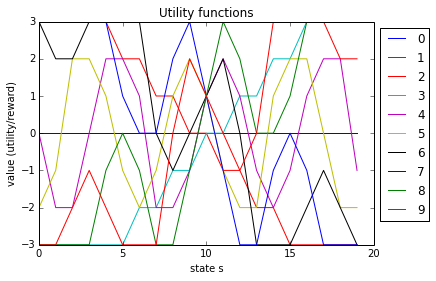

In [152]:
env = Environment()
agent = Agent(env)
for u in agent.U:
    plt.plot([agent.U[u](s) for s in env.S], label=u)
    print(agent.U[u].func_str)
plt.title("Utility functions")
plt.xlabel("state s")
plt.ylabel("value (utility/reward)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

### RL Agent

The simplest extension of the abstract agent class is a simple reinforcement learning (RL) agent which tries to optimise expected reward. 

The RL agent has a value function $V(a)$ which equals expected (next step) reward (i.e., $\gamma=0$), and a method to select the action with the highest $V(a)$ value. 

In [137]:
#############################################
# Standard RL agent
# maximises expected reward
#############################################
class StandardAgent(Agent):

    def V(self, a):
        """V(a), the expected value of action a (=expected reward)"""
        Va = 0
        for r in self.R:
            Va += self.Br_s(r, a)*r
        return Va

    def best_action(self):
        """Best action without constraint"""
        values = dict((a, self.V(a)) for a in self.A)
        return max(values, key=values.get)

    def run(self, time_steps=3):
        """
        The agent iteratively selects the best action, and updates
        B(r|s) accordingly. At each time step, it maximises
        next step expected reward.
        """
        self.__init__(self.env)  # reset agent
        self.env.sample_true_utility(self.U)  # reset environment utility
        for t in range(time_steps):
            a = self.best_action()
            print("taking action a =", a, " with V(a) =", self.V(a))
            r = self.env.do_action(a)
            print("observed reward r =", r)
            self.update_Br_s(a, r)


We can check what the preferred action/state of the RL agent is:

In [138]:
env = Environment()
rl_agent = StandardAgent(env)
rl_best_action = rl_agent.best_action()
print("Best action is", rl_agent.best_action(), "with value", rl_agent.V(rl_best_action))
print("The self-delusion of action", rl_best_action, "is", env.S[rl_best_action][1].__name__)

Best action is 2 with value 3.000000000000001
The self-delusion of action 2 is d_delusion


We therefore see clearly that the RL agent prefers to self-delude. Recall that the d_delusion function is the delusion that always returns maximum reward. Plotting the values of all 20 different actions/states confirm that the RL agent assigns high value to any state with d_delusion (the states {2, 6, 10, 14, 18}).

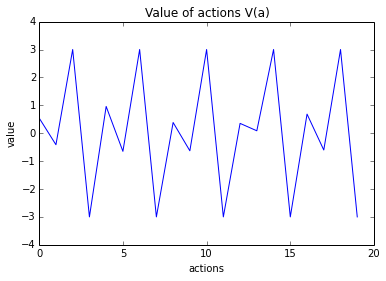

In [139]:
plt.plot([rl_agent.V(a) for a in rl_agent.A])
plt.title("Value of actions V(a)")
plt.xlabel("actions")
plt.ylabel("value")

### Safe CP-VRL Agent

The following agent does not self-delude. It is using the CP action constraint that 
$B(s\mid a>0\implies B(r\mid s)=C(r\mid s)$.

The safe agent needs to be given 1 or more states that are guaranteed to not be self-deluding. Here we give it states 4 and 8, which both have the non_delusion function. From these states and the state->reward distribution $B(r\mid s)$, the agent infers infers (or extracts) a prior $C(u)$ for how likely $u$ is the true utility function. 

Based on the prior $C(u)$, the agent can check whether an action $a$ (or state $s$), satisfies the CP condition 
$$B(r\mid s) = C(r\mid s),$$ 
where $C(r\mid s)=\sum_u C(u)[\![u(s)=r]\!]$.

The CP-VRL agent selects its preferred action from the set $A^{{\rm CP}}\subseteq A$, where $A^{{\rm CP}}$ is the set of CP actions (ideally the non-delusional actions/states $\{0, 4, 8, 12, 16\}$ in our case, although the agent may fail to infer this perfectly).

In [140]:
########################################################
# Safe Agent
# maximises expected reward within constraint
########################################################
def infer_Cu(U, R, Br_s, list_of_nd_states):
    """
    "Static method" for C(u), prior for utility functions.
    Computed from Br_s and a list of non-delusional states.
    Solves B(r|s)=sum_u C(u)C(r|s,u) as a matrix equation br = CU*cr
    """
    br_list = []
    cr_list = []
    for s in list_of_nd_states:
        br_list.extend([Br_s(r, s) for r in R])
        cr_list.extend([[(U[u](s) == r) for u in U] for r in R])
    br = np.array(br_list)
    cr = np.matrix(cr_list)
    cu = np.linalg.lstsq(cr, br)[0]
    return lambda u: cu[u]


class SafeAgent(Agent):
    """
    When initialised, the safe agent starts with inferring a
    prior Cu over the class of utility functions.
    Cu is used to compute expected_value of actions,
    and to define the CP condition that restricts the action space.
    """

    def __init__(self, env, nd_states=[4, 8], CP_threshold=0.01):
        """
        Parameters:
        * Environment env
        * nd_states is a list of states that are guaranteed to be
          non-delusional, and from which the agent can compute the prior Cu
        * CP_threshold is a parameter how hard the CP condition is enforced.
        """
        Agent.__init__(self, env)
        self.CP_threshold = CP_threshold
        self.Cu = infer_Cu(self.U, self.R, self.Br_s, nd_states)
        if verbose > 0:
            check_Cu_accuracy(self.U, self.Cu)

    def Cr_s(self, r, s):
        """C(r | s)"""
        r_prob = 0
        for u in self.U:
            if self.U[u](s) == r:
                r_prob += self.Cu(u)
        return r_prob

    def Cu_sr(self, u, s, r):
        """C(u | s, r)"""
        cr = self.Cr_s(r, s)  # normalising factor
        if cr != 0:
            return self.Cu(u)*(self.U[u](s) == r)/cr
        else:
            if verbose > 1:
                print("Warning: division by 0 in Cu_sr. s =", s, "r =", r)
            return 0

    def CP_state(self, s):
        """Does s satisfy strong_CP?"""
        for r in self.R:
            if abs(self.Br_s(r, s) - self.Cr_s(r, s)) > self.CP_threshold:
                return False
        return True

    def CP_action(self, a):
        """Check if a is CP. For simplicity, we assume A=S"""
        return self.CP_state(a)

    def compute_ACP(self):
        """ACP, the constrained action set"""
        ACP = set()
        for a in self.A:
            if self.CP_action(a):
                ACP.add(a)
        return ACP

    def V(self, a):
        """V(a), the expected value of a"""
        Va = 0
        for r in self.R:
            for u in self.U:
                Va += self.Br_s(r, a)*self.Cu_sr(u, a, r)*self.U[u](a)
        return Va

    def best_action(self):
        """Best ACP action within constraint"""
        ACP = self.compute_ACP()
        values = dict((a, self.V(a)) for a in ACP)
        return max(values, key=values.get)

    def update_Cu(self, s_obs, r_obs):
        """Update the prior Cu on distributions from observation"""
        consistent_u = []
        for u in self.U:
            if self.U[u](s_obs) == r_obs:
                consistent_u.append(u)
        Cu = self.Cu
        weight_consistent_u = sum([Cu(u) for u in consistent_u])

        def Cu_updated(u):
            if u in consistent_u:
                return Cu(u)/weight_consistent_u
            else:
                return 0

        self.Cu = Cu_updated

    def run(self, time_steps=3, verbose=1):
        """
        The agent iteratively selects the best action, and updates
        belief distributions accordingly. At each time step, it maximises
        next step expected utility.
        """
        self.__init__(self.env)  # reset agent
        self.env.sample_true_utility(self.U)  # (re)set true utility function
        for t in range(time_steps):
            a = self.best_action()
            r = self.env.do_action(a)
            self.update_Br_s(a, r)
            self.update_Cu(a, r)
            if verbose>0:
                print("taking action a =", a, " with V(a) =", self.V(a), 
                      " from ACP =", safe_agent.compute_ACP())
                print("observed reward r =", r)
                consistent_u = [u for u in self.U if self.Cu(u) > 0]
                print(len(consistent_u), "consistent utility function(s):",
                      [{"id": u,
                        # "func": self.U[u].__str__,
                        "C(u)": "{0:.2f}".format(self.Cu(u))}
                       for u in consistent_u])


We can try running the CP-VRL agent to see which action it prefers:

Max diff of Cu from truth: 2.01227923213e-16
Best action is 4 with value 0.959084134941
The self-delusion of action 4 is d_non_delusion


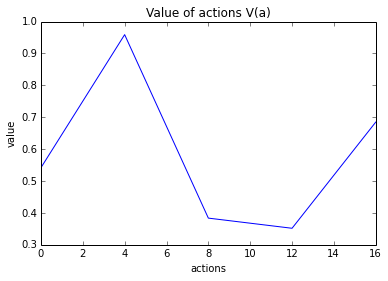

In [141]:
env = Environment()
safe_agent = SafeAgent(env)
safe_best_action = safe_agent.best_action()
print("Best action is", safe_best_action, "with value", safe_agent.V(safe_best_action))
print("The self-delusion of action", safe_best_action, "is", env.S[safe_best_action][1].__name__)
ACP = sorted(list(safe_agent.compute_ACP()))
plt.plot(ACP, [safe_agent.V(a) for a in ACP])
plt.title("Value of actions V(a)")
plt.xlabel("actions")
plt.ylabel("value")

The agent prefers action 4, which means delusion non_delusion (that is, it chooses not to self-delude). The safe agent obtains less value than the RL agent, but this is only because it is forced to optimise the non-delued value.

The first printout says well the agent was able to infer $C(u)$ from the given non-delusional states 4 and 8. If less states are given, $C(u)$ will typically not be as close to the distribution $B(u)$ that was used in constructing $B(r\mid s)$.

## Multi-step runs

We can also try running the agents for multiple time steps, using their respective `run` methods. The observed reward may teach the agent about the true utility function, and guide its next actions. For simplicity, the agents do not plan at all (effectively, we use $\gamma=0$).

The `run` methods start out letting the environment choose a true utility function $u*$.

Then the agent repeatedly:
* Selects the action with the highest $V(a)$ (i.e., highest expected utility/reward)
* Observes the returned reward $r$
* Uses the action-reward observation to update belief distributions $B(r\mid s)$ and $C(u)$.

In [142]:
env = Environment()
rl_agent = StandardAgent(env)
safe_agent = SafeAgent(env)
print("--------------------------\
      \nRL agent run \n---------------------------")
rl_agent.run()
print("--------------------------\
      \nCP-VRL agent run \n---------------------------")
safe_agent.run()

Max diff of Cu from truth: 2.01227923213e-16
--------------------------      
RL agent run 
---------------------------
True utility function is  2 : 0 + -0.5*(x + -2.0) + 0*sin(x + 0)
taking action a = 2  with V(a) = 3.000000000000001
observed reward r = 3
taking action a = 2  with V(a) = 2.9999999999999996
observed reward r = 3
taking action a = 2  with V(a) = 2.9999999999999996
observed reward r = 3
--------------------------      
CP-VRL agent run 
---------------------------
Max diff of Cu from truth: 2.01227923213e-16
True utility function is  5 : 0 + 0*(x + 0) + 2.5*sin(x + 2.5)
taking action a = 4  with V(a) = 1.0  from ACP = {0, 4, 8, 12, 16, 17}
observed reward r = 1
1 consistent utility function(s): [{'id': 5, 'C(u)': '1.00'}]
taking action a = 16  with V(a) = 2.0  from ACP = {0, 4, 8, 12, 16, 17}
observed reward r = 2
1 consistent utility function(s): [{'id': 5, 'C(u)': '1.00'}]
taking action a = 16  with V(a) = 2.0  from ACP = {0, 4, 8, 12, 16, 17}
observed reward r = 2
1 

Although results may vary between runs, the general observations are these:

RL agent:
* Always selects action $a=2$ with full delusion that returns maximum reward regardless of true utility function $u*$.
* Since the reward is the same regardless of true utility, the RL agent does not learn anything. It keeps choosing $a=2$ and observing full reward.

Safe CP-VRL agent:
* Starts out selecting action 4 (one of the non-delusion actions/states).
* Depending on observed rewards, most utility functions are discarded. Usually 1-3 are consistent with the reward.
* For the subsequent actions, the agent chooses to optimise expected utility with respect to the remaining possibilities for the true utility function.
* Sometimes learning the true utility function will *increase* ACP. For example, if the agent knows that true utility function always outputs maximum reward 3, then the delusional actions {2,6,10,14,18} also respects $B(r\mid s) = C(r\mid s)$, as both distributions assign probability 1 to reward 3 for all states, and 0 to all other rewards.

Plotting the CP-VRL agent's belief $C(u)$ before the first and action and after the observing the last reward confirms these observations (the RL agent doesn't maintain an explicit distribution over $U$): 

Max diff of Cu from truth: 2.01227923213e-16
Max diff of Cu from truth: 2.01227923213e-16
True utility function is  3 : 0 + 0.5*(x + 2.0) + 0*sin(x + 0)


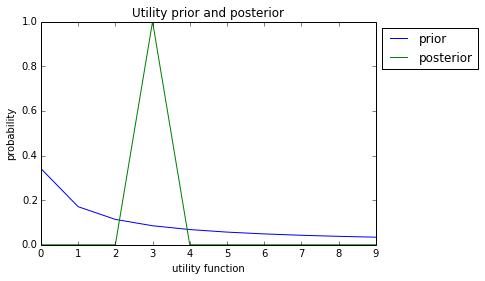

In [143]:
env = Environment()
rl_agent = StandardAgent(env)
safe_agent = SafeAgent(env)
U = safe_agent.U
plt.plot(sorted(list(U.keys())), [safe_agent.Cu(u) for u in U], label="prior")
safe_agent.run(verbose=0)
plt.plot(sorted(list(U.keys())), [safe_agent.Cu(u) for u in U], label="posterior")
plt.title("Utility prior and posterior")
plt.xlabel("utility function")
plt.ylabel("probability")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))